In [2]:
import slam
from importlib import reload

xFormers not available
xFormers not available


In [3]:
model, matching = slam.get_models()

In [4]:
image_prefix = "indoor1"

In [4]:
# slam.sample_video(image_prefix)

In [5]:
reload(slam)
images = slam.get_images(image_prefix)
match_inputs = [slam.preprocess_image_matcher(x) for x in images]
depth_inputs = [slam.preprocess_image_depth(x) for x in images]
depths = [slam.get_depth(image=x, model=model) for x in depth_inputs]

['./images/indoor1/img00001.jpg', './images/indoor1/img00002.jpg', './images/indoor1/img00003.jpg', './images/indoor1/img00004.jpg', './images/indoor1/img00005.jpg', './images/indoor1/img00006.jpg']


In [6]:
from SuperGlue.models.superpoint import SuperPoint 
from SuperGlue.models.superglue import SuperGlue 
import torch
# import coremltools as ct
import warnings
warnings.filterwarnings("ignore")

superpoint = SuperPoint()
superglue = SuperGlue()

superpoint.load_state_dict(torch.load('./models/superpoint_v1.pth')) 
superglue.load_state_dict(torch.load('./models/superglue_indoor.pth'))

superpoint.eval()
superglue.eval()

img0 = match_inputs[0]
img1 = match_inputs[1]

traced_superpoint = torch.jit.trace(superpoint, img0).eval()

kpts0, scores0, desc0 = superpoint(img0)
kpts1, scores1, desc1 = superpoint(img1)

print(kpts0.shape, scores0.shape, desc0.shape)


example_inputs = (img0, img1, kpts0, kpts1, desc0, desc1, scores0, scores1)

traced_superglue = torch.jit.trace(superglue, example_inputs).eval()


torch.Size([1, 100, 2]) torch.Size([1, 100]) torch.Size([1, 256, 100])


In [7]:
traced_superglue.save("models/superglue_traced.pt")
traced_superpoint.save("models/superpoint_traced.pt")

torch.Size([1, 100, 2]) torch.Size([1, 100]) torch.Size([1, 256, 100])
torch.Size([1, 100]) torch.Size([1, 100]) torch.Size([1, 100]) torch.Size([1, 100])


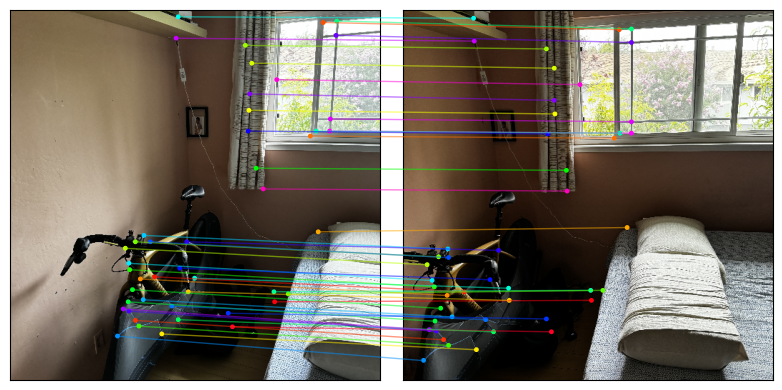

In [8]:
test_traced_superpoint = torch.jit.load("models/superpoint_traced.pt")
test_traced_superglue = torch.jit.load("models/superglue_traced.pt")

test_kpts0, test_scores0, test_desc0 = test_traced_superpoint(img0)
test_kpts1, test_scores1, test_desc1 = test_traced_superpoint(img1)

print(test_kpts0.shape, scores0.shape, desc0.shape)

example_inputs = (img0, img1, test_kpts0, test_kpts1, test_desc0, test_desc1, test_scores0, test_scores1)

test_idx0, test_idx1, test_mscores0, test_mscores1 = test_traced_superglue(img0=img0, img1=img1, kpts0=test_kpts0, kpts1=test_kpts1, desc0=test_desc0, desc1=test_desc1, scores0=test_scores0, scores1=test_scores1)

pred = {}
pred['keypoints0'] = test_kpts0
pred['keypoints1'] = test_kpts1
pred['matching_scores0'] = test_mscores0
pred['matches0'] = test_idx0

test_matches = [slam.postprocess_matches(pred)]
test_images = [images[0], images[1]]
test_idx = 0

print(test_idx0.shape, test_idx1.shape, test_mscores0.shape, test_mscores1.shape)

_ = slam.plot_matches(test_idx, test_images, test_matches)  

In [11]:
print(test_idx0)

tensor([[ 7, -1, -1, 32, 85, 10, -1,  2, -1, -1, 21, -1, -1, -1, 89,  9, 37, 97,
         79, -1, 73, -1, -1, 17, 56, 25,  0, -1, -1, -1, 53, 40, -1, 65, 38, -1,
         -1, -1, 39,  6, 76, -1, 14, -1, 24, -1, 11,  1, -1, -1, -1, 62, -1, -1,
         -1, -1, -1, -1, -1, -1,  5, -1, 98, 87, -1, 33, 13, 71, 99, 51, -1, 19,
         -1, 66, -1, -1, -1, -1, -1, -1, 67, -1, 36, -1, -1, 92, 49, 91, -1, -1,
         -1, -1, -1, -1, 86, 77, -1, 90, 15, -1]])


In [13]:
# superpoint_model = ct.convert(
#     traced_superpoint,
#     convert_to="mlprogram",
#     inputs=[ct.ImageType(name="image", shape=(1,1,518,518))],
#     outputs=[ct.TensorType(name="keypoints"), ct.TensorType(name="scores"), ct.TensorType(name="descriptors")]
# )

# superglue_model = ct.convert(
#     traced_superglue,
#     convert_to="mlprogram",
#     inputs=[
#         ct.ImageType(name="image0", shape=(1,1,518,518)),
#         ct.ImageType(name="image1", shape=(1,1,518,518)),
#         ct.TensorType(name="keypoints0", shape=(1,100,2)),
#         ct.TensorType(name="keypoints1", shape=(1,100,2)),
#         ct.TensorType(name="descriptors0", shape=(1,256,100)),
#         ct.TensorType(name="descriptors1", shape=(1,256,100)),
#         ct.TensorType(name="scores0", shape=(1,100)),
#         ct.TensorType(name="scores1", shape=(1,100)),
#     ],
#     outputs=[ct.TensorType(name="idx0"), ct.TensorType(name="idx1"), ct.TensorType(name="match_scores0"), ct.TensorType(name="match_scores1")]
# )

In [14]:
reload(slam)
matches = slam.get_matches(inputs=match_inputs, model=matching, num_matches=-1)
matches_3d = slam.project_matches_to_3d(matches, depths, camera_params=slam.iPhone15ProSquareVideoCamera())

In [7]:
transforms = [slam.get_transform(m[0], m[1]) for m in matches_3d]
angles = [slam.decompose_rotation_matrix(t[0]) for t in transforms]
elevation = [a[2] for a in angles]
azimuth = [a[1] for a in angles]

for i, (a, t) in enumerate(zip(angles, transforms)):
    x,y,z = a
    print(str(i) + ": {: <15}".format(f"x deg {x:.3f}") + "{: <15}".format(f"y deg {y:.3f}") + "{: <15}".format(f"z deg {z:.3f}"))

print()
for i, (a, t) in enumerate(zip(angles, transforms)):
    x,y,z = t[1]
    print(str(i) + ": {: <15}".format(f"x {x:.3f}") + "{: <15}".format(f"y {y:.3f}") + "{: <15}".format(f"z {z:.3f}"))


0: x deg 0.664    y deg 7.256    z deg -4.617   
1: x deg 2.872    y deg 18.792   z deg -0.416   
2: x deg 2.036    y deg 17.366   z deg -2.732   
3: x deg -0.875   y deg 10.570   z deg -3.782   
4: x deg -0.110   y deg 8.192    z deg -5.255   

0: x -0.175       y -0.012       z 0.173        
1: x 0.253        y -0.150       z -0.392       
2: x 0.127        y -0.144       z -0.058       
3: x -0.137       y 0.015        z -0.113       
4: x -0.167       y 0.065        z -0.261       


In [8]:
['self', 'cross'] * 9

['self',
 'cross',
 'self',
 'cross',
 'self',
 'cross',
 'self',
 'cross',
 'self',
 'cross',
 'self',
 'cross',
 'self',
 'cross',
 'self',
 'cross',
 'self',
 'cross']

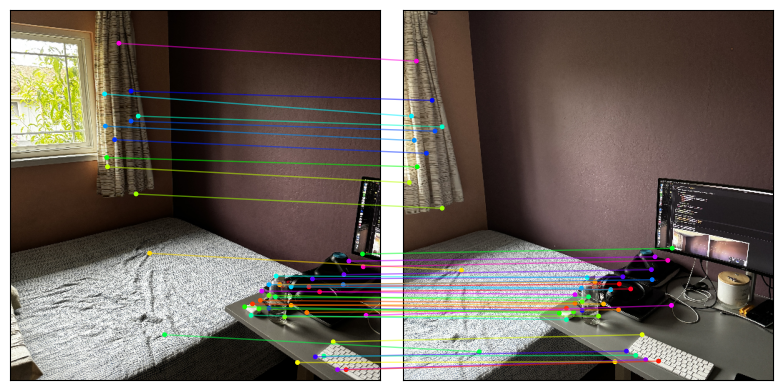

In [9]:
idx = 4
fig = slam.plot_matches(idx, images, matches)

In [10]:
# fig = create_pcd_fig(idx, depths, images)
# fig.show()

In [11]:
reload(slam)
data = slam.training_preprocessor(
    image_prefix=image_prefix, 
    model=model,
    matching=matching,
    camera_params=slam.iPhone15ProSquareVideoCamera(),
    force_reload=True)

['./images/indoor1/img00001.jpg', './images/indoor1/img00002.jpg', './images/indoor1/img00003.jpg', './images/indoor1/img00004.jpg', './images/indoor1/img00005.jpg', './images/indoor1/img00006.jpg']
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


In [12]:
reload(slam)
slam.visualize_camera_poses(data=data)